In [3]:
import numpy as np
import os 
import torch
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset

In [4]:
def is_image(fn):
    extensions = ['.jpg', '.jpeg', '.png']
    return any(fn.lower().endswith(ext) for ext in extensions)

def find_images_in_folder(folder_path, verbose=False):
    full_image_paths = []
    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        # Check if the file is an image
        if os.path.isfile(file_path) and is_image(filename):
            # Try opening the image
            try:
                im = Image.open(file_path)
                full_image_paths.append(file_path)
                if verbose:
                    print(f"Read image: {file_path}")
            except Exception as e:
                print(f"Error failed to read {filename}: {e}")
    print(f'Returing {len(full_image_paths)} image paths')
    return full_image_paths

folder_path = "hw4_data/valid/ocean"
full_paths = find_images_in_folder(folder_path, verbose=False)


Returing 150 image paths


In [5]:
'''
Provide a Dataset object for the five class dataset.
'''

# These are empirically determined values to optimize image intensity rescaling prior to training
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

'''
The Dataset class we write must include the __init__, __len__ and __getitem__ (subscripting) 
methods.
'''
class HW4_Dataset(Dataset):
    def __init__(self, path, class_names, new_size=None, verbose=False):
        '''
        Produce a list of the full image paths and class indices for all images
        in the given set (found along the path).  Record a transform to be
        applied by the __getitem__ method to each image.
        '''
        self.full_image_paths = []
        self.class_names = class_names
        self.gt_class_idx = []
        for idx, nm in enumerate(class_names):
            folder_path = os.path.join(path, nm)
            image_paths = find_images_in_folder(folder_path, verbose)
            self.full_image_paths += image_paths
            self.gt_class_idx += [idx] * len(image_paths)

        if new_size is not None:
            self.transform = transforms.Compose([transforms.Resize(new_size),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(mean=MEAN, std=STD)])
        else:
            self.transform = transforms.Compose([transforms.ToTensor(),
                                                 transforms.Normalize(mean=MEAN, std=STD)])

    def __len__(self):
        return len(self.full_image_paths)

    def __getitem__(self, idx):
        fp = self.full_image_paths[idx]
        class_i = self.gt_class_idx[idx]
        im = Image.open(fp)
        im = self.transform(im)
        return im, class_i
        
class_names = ['grass', 'ocean', 'redcarpet', 'road', 'wheatfield']

# new_size = 60   # This reduces the original 240x360 images to 60x90.  Setting it to 240 leaves the images unchanged
new_size = None # Setting new_size to None keeps the original image size.
verbose = False

# Form all three datasets.
train_dataset = HW4_Dataset("hw4_data/train", class_names, new_size=new_size, verbose=verbose)
valid_dataset = HW4_Dataset("hw4_data/valid", class_names, new_size=new_size, verbose=verbose)
test_dataset = HW4_Dataset("hw4_data/test", class_names, new_size=new_size, verbose=verbose)


Returing 700 image paths
Returing 700 image paths
Returing 700 image paths
Returing 700 image paths
Returing 700 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths
Returing 150 image paths


The validation dataset has 750 images
After the shuffle the 0th image has class index 1
Image shape is (240, 360, 3)


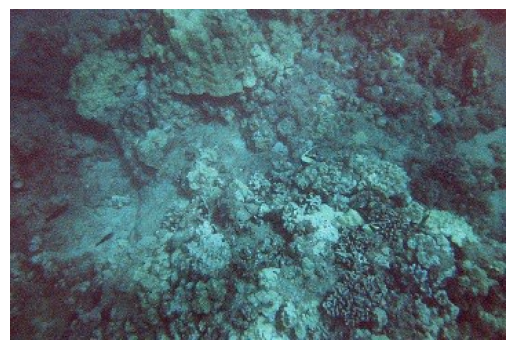

1


In [6]:
'''
Explore the constructed dataset
'''
import random
import matplotlib.pyplot as plt

# Find and output the number of images
n = len(valid_dataset)
print(f'The validation dataset has {n} images')

# Randomly shuffle the image indices
indices = list(range(n))
random.shuffle(indices)

# Get the image and the class id of the 0th image after the shuffle.
im, class_idx = valid_dataset[indices[0]]
print(f'After the shuffle the 0th image has class index {class_idx}')

# Convert the image from an array back to a numpy 3d array
im_np = im.numpy().transpose((1, 2, 0))
print(f'Image shape is {im_np.shape}')

# Before displaying the image rescale the intensities to be between 0 and 1
im_min = im_np.min()
im_max = im_np.max()
im_np = (im_np - im_min) / (im_max - im_min)

# Display the image
plt.imshow(im_np)
plt.axis('off')
plt.show()
print(class_idx)

Epoch 1: Train Loss=1.6053, Valid Loss=1.6008, Valid Accuracy=0.2013
New best model saved at epoch 1
Epoch 2: Train Loss=1.5952, Valid Loss=1.5908, Valid Accuracy=0.2827
New best model saved at epoch 2
Epoch 3: Train Loss=1.5849, Valid Loss=1.5801, Valid Accuracy=0.3587
New best model saved at epoch 3
Epoch 4: Train Loss=1.5734, Valid Loss=1.5673, Valid Accuracy=0.4400
New best model saved at epoch 4
Epoch 5: Train Loss=1.5590, Valid Loss=1.5507, Valid Accuracy=0.5240
New best model saved at epoch 5
Epoch 6: Train Loss=1.5406, Valid Loss=1.5292, Valid Accuracy=0.5693
New best model saved at epoch 6
Epoch 7: Train Loss=1.5159, Valid Loss=1.5005, Valid Accuracy=0.6067
New best model saved at epoch 7
Epoch 8: Train Loss=1.4823, Valid Loss=1.4607, Valid Accuracy=0.6360
New best model saved at epoch 8
Epoch 9: Train Loss=1.4358, Valid Loss=1.4053, Valid Accuracy=0.6427
New best model saved at epoch 9
Epoch 10: Train Loss=1.3726, Valid Loss=1.3315, Valid Accuracy=0.6547
New best model saved 

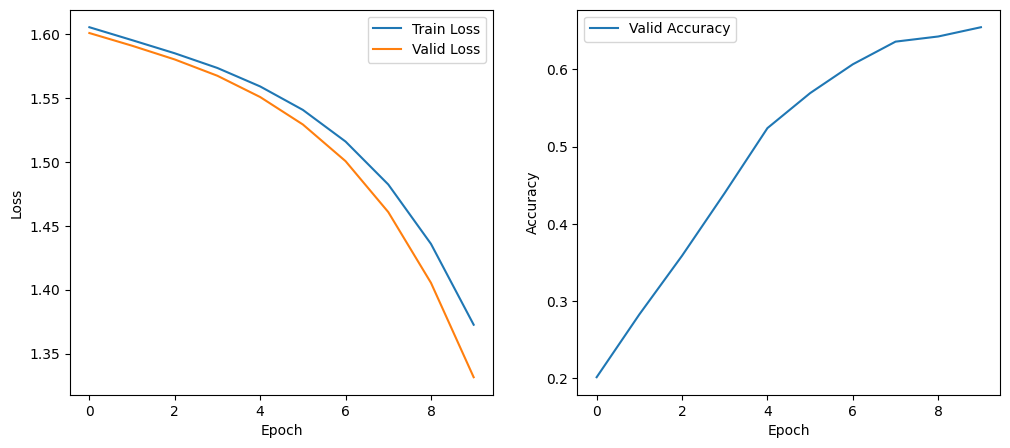

Overall Accuracy: 0.5893

Per class accuracy:
Class grass: 0.3333
Class ocean: 0.7267
Class redcarpet: 0.7800
Class road: 0.4133
Class wheatfield: 0.6933


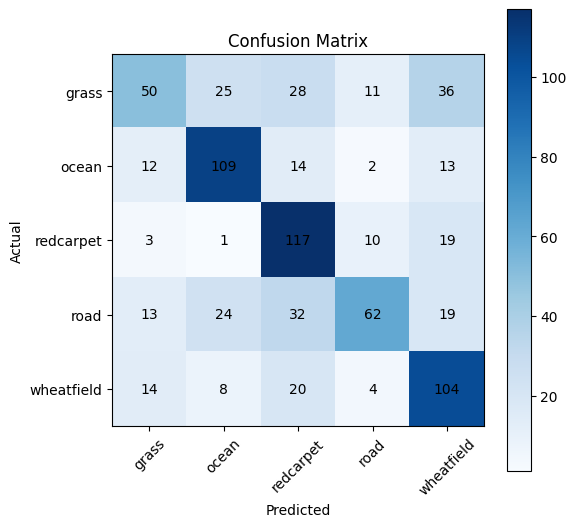

In [7]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

class HW4NET(nn.Module):
    def __init__(self, input_channels=3, num_classes=5):
        super(HW4NET, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Adaptive pooling layer to resize the output to (7, 7)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))

        # Initial fully connected layer size is based on (128 * 7 * 7) after adaptive pooling
        self.fc_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 128),  # Update based on output size after pooling
            nn.ReLU(),
            nn.Linear(128, num_classes),  # Final layer size based on num_classes
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.adaptive_pool(x)  # Apply adaptive pooling to resize to (7, 7)
        logits = self.fc_stack(x)
        return logits


# Initialize neural net
device = "cuda" if torch.cuda.is_available() else "cpu"

model = HW4NET(num_classes=len(train_dataset.class_names)).to(device)

# Hyperparameters
batch_size = 32
epochs = 10
learning_rate = 0.001

# DataLoaders using the HW4_Dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
train_losses, valid_losses, valid_accuracies = [], [], []
best_accuracy = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Validation
    model.eval()
    valid_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    valid_loss = valid_loss / len(valid_loader)
    valid_accuracy = correct / total
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)
    
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Valid Loss={valid_loss:.4f}, Valid Accuracy={valid_accuracy:.4f}")
    
    if valid_accuracy > best_accuracy:
        best_accuracy = valid_accuracy
        # torch.save(model.state_dict(), "best_model.pth")
        print(f"New best model saved at epoch {epoch+1}")

# Plot training progress
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Testing
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
test_preds, test_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(test_labels, test_preds)
conf_matrix = confusion_matrix(test_labels, test_preds)
print(f"Overall Accuracy: {accuracy:.4f}")


# Display per class accuracy
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

print("\nPer class accuracy:")
for i, class_name in enumerate(train_dataset.class_names):
    print(f"Class {class_name}: {class_accuracies[i]:.4f}")

# Confusion Matrix Plot
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, cmap='Blues')
plt.colorbar()
plt.xticks(ticks=np.arange(len(train_dataset.class_names)), labels=train_dataset.class_names, rotation=45)
plt.yticks(ticks=np.arange(len(train_dataset.class_names)), labels=train_dataset.class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Annotate the confusion matrix
for i in range(len(train_dataset.class_names)):
    for j in range(len(train_dataset.class_names)):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='black')

plt.show()
